In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import numpy as np
from tqdm import tqdm,trange
import matplotlib.pyplot as plt
import numba

### Setup parameters

In [2]:
infile = "data/signal/wza_UL18_sum.root" # --signal
#infile = "data/mc/ZZ/5B850510-FC7D-AD4C-A534-33F6C24D14D1.root"
#infile = "data/mc/TTZToLL/30FD3469-AEFB-B742-8F3E-4551B23D529B.root"
#infile='data/data/7B56E217-555E-1C41-9494-491849A9835F_skim_2ElIdPt20.root' # --data 
#infile = 'data/data/CA42F3A2-614F-4A4F-AF18-F6E66CDA2C85_skim_2ElIdPt20.root'
#infile = 'data/Ntuple/EGamma_Run2018B.root'
#infile="data/mc/59AB328B-F0E3-F544-98BB-E5E55577C649_skim_2ElIdPt20.root" # --mc

dataset="WZG"
year='2018'

In [3]:
events = NanoEventsFactory.from_root(infile, schemaclass=NanoAODSchema).events()

In [4]:
# Trigger set
doubleelectron_triggers  ={
    '2018': [
            "Ele23_Ele12_CaloIdL_TrackIdL_IsoVL", # Recomended
            ]
}



singleelectron_triggers = { #2017 and 2018 from monojet, applying dedicated trigger weights
        '2016': [
            'Ele27_WPTight_Gsf',
            'Ele105_CaloIdVT_GsfTrkIdT'
        ],
        '2017': [
            'Ele35_WPTight_Gsf',
            'Ele115_CaloIdVT_GsfTrkIdT',
            'Photon200'
        ],
        '2018': [
            'Ele32_WPTight_Gsf',    # Recomended
        ]
    }



isData = "genWeight" not in events.fields


# Golden Json file
if (year == "2018") and isData:
    injson = "data/json/Cert_314472-325175_13TeV_Legacy2018_Collisions18_JSON.txt.RunABD"

### Helper functions

In [5]:
# << Sort by PT  helper function >>
def sort_by_pt(ele,pho,jet):
    ele = ele[ak.argsort(ele.pt,ascending=False,axis=1)]
    pho = pho[ak.argsort(pho.pt,ascending=False,axis=1)]
    jet = jet[ak.argsort(jet.pt,ascending=False,axis=1)]

    return ele,pho,jet
events.Electron, events.Photon, events.Jet = sort_by_pt(
            events.Electron, events.Photon, events.Jet
        )

# Lorentz vectors
from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

def TLorentz_vector(vec):
    vec = ak.zip(
        {"x": vec.x, "y": vec.y, "z": vec.z, "t": vec.t},
        with_name="LorentzVector",
    )
    return vec

def TLorentz_vector_cylinder(vec):

    vec = ak.zip(
        {
            "pt": vec.pt,
            "eta": vec.eta,
            "phi": vec.phi,
            "mass": vec.mass,
        },
        with_name="PtEtaPhiMLorentzVector",
    )

    return vec



### Good-Run check ( Data-only )

In [6]:
from coffea import lumi_tools

if isData:
    lumi_mask_builder = lumi_tools.LumiMask(injson)
    lumimask = ak.Array(
        lumi_mask_builder.__call__(events.run, events.luminosityBlock)
    )
    events = events[lumimask]

### 1. Trigger

In [7]:
# double lepton trigger
is_double_ele_trigger=True
if not is_double_ele_trigger:
    double_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    double_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in doubleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        double_ele_triggers_arr = double_ele_triggers_arr | events.HLT[path]


# single lepton trigger
is_single_ele_trigger=True
if not is_single_ele_trigger:
    single_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    single_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in singleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        single_ele_triggers_arr = single_ele_triggers_arr | events.HLT[path]

# Sort particle order by PT  # RunD --> has problem
events.Electron,events.Photon,events.Jet = sort_by_pt(events.Electron,events.Photon,events.Jet)

Initial_events = events
#events = events[single_ele_triggers_arr | double_ele_triggers_arr]
events = events[double_ele_triggers_arr]
print("Events passing triggers and skiimig: ",len(events) )

Events passing triggers and skiimig:  22276


In [8]:
# Set Particle
Electron = events.Electron
Muon = events.Muon
Photon = events.Photon
MET = events.MET
Jet = events.Jet

### 2. Lepton Selection: e e mu

In [9]:
#  --Muon 
MuSelmask = (
    (Muon.pt >= 10)
    & (abs(Muon.eta) <= 2.5)
    & (Muon.tightId)
    & (Muon.pfRelIso04_all < 0.15)
)
# Muon = ak.mask(Muon,MuSelmask)
Muon = Muon[MuSelmask]

In [10]:
# Reference: VBS Zgamma+2jets
LoooseMuSelmask = (
    (Muon.pt > 20)
    & (abs(Muon.eta) < 2.4)
    & (Muon.isPFcand)
    & (Muon.isGlobal | Muon.isTracker)
    & (Muon.pfRelIso03_all < 0.25)
)

VetoMuon = Muon[LoooseMuSelmask]

In [11]:
##----------- Cut flow2: Electron Selection

EleSelmask = (
    (Electron.pt >= 10)
    & (np.abs(Electron.eta + Electron.deltaEtaSC) < 1.479)
    & (Electron.cutBased > 2)
    & (abs(Electron.dxy) < 0.05)
    & (abs(Electron.dz) < 0.1)
) | (
    (Electron.pt >= 10)
    & (np.abs(Electron.eta + Electron.deltaEtaSC) > 1.479)
    & (np.abs(Electron.eta + Electron.deltaEtaSC) <= 2.5)
    & (Electron.cutBased > 2)
    & (abs(Electron.dxy) < 0.1)
    & (abs(Electron.dz) < 0.2)
)

Electron = Electron[EleSelmask]

In [12]:
# apply cut 2
eemu_mask = (ak.num(Electron) ==2) & (ak.num(Muon) ==1)

Electron = Electron[eemu_mask]
Photon = Photon[eemu_mask]
Jet = Jet[eemu_mask]
MET = MET[eemu_mask]
Muon = Muon[eemu_mask]
VetoMuon = VetoMuon[eemu_mask]
events = events[eemu_mask]

In [13]:
len(events)

2204

In [14]:
# veto 4th Muon
#fourth_lepton_veto = ak.num(VetoMuon ) < 1
#Electron = Electron[fourth_lepton_veto]
#Photon = Photon[fourth_lepton_veto]
#Jet = Jet[fourth_lepton_veto]
#MET = MET[fourth_lepton_veto]
#Muon = Muon[fourth_lepton_veto]
#events = events[fourth_lepton_veto]

In [15]:
#len(events)

### 3. Photon Selection:  pho > 0 

In [16]:
##----------- Cut flow3: Photon Selection

# Basic photon selection
isgap_mask = (abs(Photon.eta) < 1.442) | (
    (abs(Photon.eta) > 1.566) & (abs(Photon.eta) < 2.5)
)
Pixel_seed_mask = ~Photon.pixelSeed

if (dataset == "ZZ") and (year == "2017"):
    PT_ID_mask = (Photon.pt >= 20) & (
        Photon.cutBasedBitmap >= 3
    )  # 2^0(Loose) + 2^1(Medium) + 2^2(Tights)
else:
    PT_ID_mask = (Photon.pt >= 20) & (Photon.cutBased > 1)

# dR cut with selected Muon and Electrons
dr_pho_ele_mask = ak.all(
    Photon.metric_table(Electron) >= 0.5, axis=-1
)  # default metric table: delta_r
dr_pho_mu_mask = ak.all(Photon.metric_table(Muon) >= 0.5, axis=-1)

# genPartFlav cut
"""
if dataset == "WZG":
    isPrompt = (Photon.genPartFlav == 1) | (Photon.genPartFlav == 11)
    PhoSelmask = PT_ID_mask & isgap_mask &  Pixel_seed_mask & isPrompt & dr_pho_ele_mask & dr_pho_mu_mask
elif dataset == "WZ":
    isPrompt = (Photon.genPartFlav == 1) 
    PhoSelmask = PT_ID_mask & isgap_mask &  Pixel_seed_mask & ~isPrompt & dr_pho_ele_mask & dr_pho_mu_mask

else:
    PhoSelmask = PT_ID_mask  & isgap_mask &  Pixel_seed_mask & dr_pho_ele_mask & dr_pho_mu_mask
"""

PhoSelmask = (
    PT_ID_mask & isgap_mask & Pixel_seed_mask & dr_pho_ele_mask & dr_pho_mu_mask
)
Photon = Photon[PhoSelmask]

In [17]:
# Apply cut 3
A_photon_mask = ak.num(Photon) > 0
Electron = Electron[A_photon_mask]
Photon = Photon[A_photon_mask]
Jet = Jet[A_photon_mask]
Muon = Muon[A_photon_mask]
MET = MET[A_photon_mask]
events = events[A_photon_mask]

In [18]:
len(events)

595

### 4. OSSF Selection

In [19]:
ossf_mask = Electron.charge[:,0] + Electron.charge[:,1] == 0

In [20]:
# Apply cut 4
Electron = Electron[ossf_mask]
Photon = Photon[ossf_mask]
Jet = Jet[ossf_mask]
MET = MET[ossf_mask]
Muon = Muon[ossf_mask]
events = events[ossf_mask]

In [21]:
len(events)

588

In [22]:
# Define Electron Triplet
Diele = ak.zip(
    {
        "lep1": Electron[:,0],
        "lep2": Electron[:,1],
        "p4": TLorentz_vector(Electron[:,0] + Electron[:,1]),
    }
)


leading_ele =Diele.lep1
subleading_ele = Diele.lep2

def make_leading_pair(target, base):
    return target[ak.argmax(base.pt, axis=1, keepdims=True)]

leading_pho = make_leading_pair(Photon, Photon)

### 5. Event selection

In [23]:
# Mee cut
Mee_cut_mask = Diele.p4.mass > 4

# Lepton-PT cuts
Leppt_mask = ak.firsts((Diele.lep1.pt >= 25) & (Diele.lep2.pt >= 10) & (Muon.pt >= 25))

# MET cuts
MET_mask = MET.pt > 20
                       
                       
Event_sel_mask = Mee_cut_mask & Leppt_mask & MET_mask

In [24]:
# Apply cut5
Diele_sel = Diele[Event_sel_mask]
leading_pho_sel = leading_pho[Event_sel_mask]
MET_sel = MET[Event_sel_mask]
Muon_sel = Muon[Event_sel_mask]
events = events[Event_sel_mask]

In [25]:
len(events)

437

In [26]:
# Photon  EE and EB
isEE_mask = leading_pho.isScEtaEE
isEB_mask = leading_pho.isScEtaEB
Pho_EE = leading_pho[isEE_mask & Event_sel_mask]
Pho_EB = leading_pho[isEB_mask & Event_sel_mask]

### 6. Prepare hist

In [63]:
# Photon
phoPT = ak.flatten(leading_pho_sel.pt)
phoEta = ak.flatten(leading_pho_sel.eta)
phoPhi = ak.flatten(leading_pho_sel.phi)

# Photon EE
if len(Pho_EE.pt) != 0:
    Pho_EE_PT = ak.flatten(Pho_EE.pt)
    Pho_EE_Eta = ak.flatten(Pho_EE.eta)
    Pho_EE_Phi = ak.flatten(Pho_EE.phi)
    Pho_EE_sieie = ak.flatten(Pho_EE.sieie)
    Pho_EE_Iso_charge = ak.flatten(Pho_EE.pfRelIso03_chg)

# Photon EB
if len(Pho_EB.pt) != 0:
    Pho_EB_PT = ak.flatten(Pho_EB.pt)
    Pho_EB_Eta = ak.flatten(Pho_EB.eta)
    Pho_EB_Phi = ak.flatten(Pho_EB.phi)
    Pho_EB_sieie = ak.flatten(Pho_EB.sieie)
    Pho_EB_Iso_charge = ak.flatten(Pho_EB.pfRelIso03_chg)

# Electrons
ele1PT  = Diele_sel.lep1.pt
ele1Eta = Diele_sel.lep1.eta
ele1Phi = Diele_sel.lep1.phi

ele2PT  = Diele_sel.lep2.pt
ele2Eta = Diele_sel.lep2.eta
ele2Phi = Diele_sel.lep2.phi

muPT  = Muon_sel.pt
muEta = Muon_sel.eta
muPhi = Muon_sel.phi


# MET
met = ak.to_numpy(MET_sel.pt)

# M(eea) M(ee)
diele =  Diele_sel.p4
eeg_vec = diele + leading_pho_sel
Meea = eeg_vec.mass
Mee = Diele_sel.p4.mass

# W MT (--> beta )

dPhi_mumet = abs(MET_sel.delta_phi(Muon_sel))

MT = np.sqrt(
    2 * Muon_sel.pt * MET_sel.pt * (1 - np.cos(abs(MET_sel.delta_phi(Muon_sel))))
)
MT = np.array(MT)

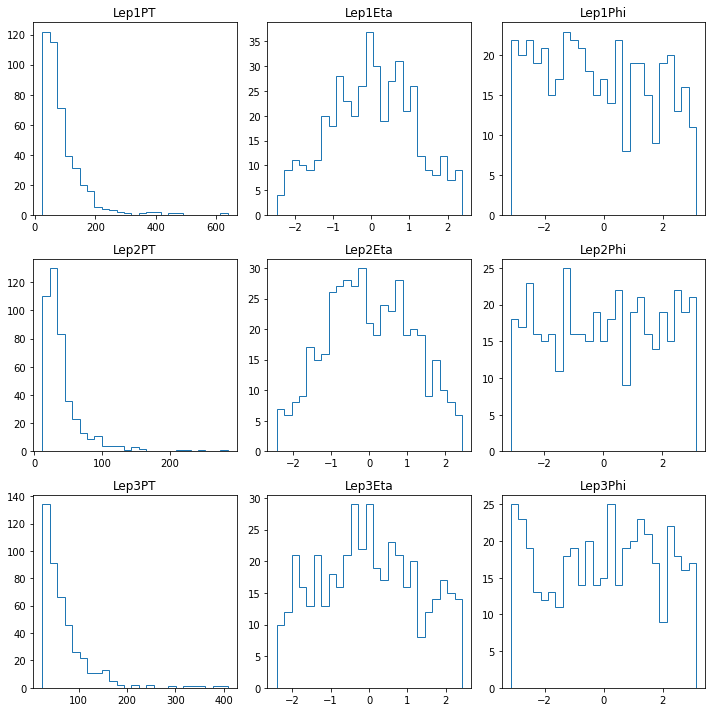

In [42]:
fig,axs = plt.subplots(3,3,figsize=(10,10))
#axs = axs.ravel()
bins=25

axs[0,0].hist(ele1PT,bins=bins,histtype='step')
axs[0,0].set_title('Lep1PT')
axs[0,1].hist(ele1Eta,bins=bins,histtype='step')
axs[0,1].set_title('Lep1Eta')
axs[0,2].hist(ele1Phi,bins=bins,histtype='step')
axs[0,2].set_title('Lep1Phi')

axs[1,0].hist(ele2PT,bins=bins,histtype='step')
axs[1,0].set_title('Lep2PT')
axs[1,1].hist(ele2Eta,bins=bins,histtype='step')
axs[1,1].set_title('Lep2Eta')
axs[1,2].hist(ele2Phi,bins=bins,histtype='step')
axs[1,2].set_title('Lep2Phi')

axs[2,0].hist(muPT,bins=bins,histtype='step')
axs[2,0].set_title('Lep3PT')
axs[2,1].hist(muEta,bins=bins,histtype='step')
axs[2,1].set_title('Lep3Eta')
axs[2,2].hist(muPhi,bins=bins,histtype='step')
axs[2,2].set_title('Lep3Phi')
plt.tight_layout()
plt.show()

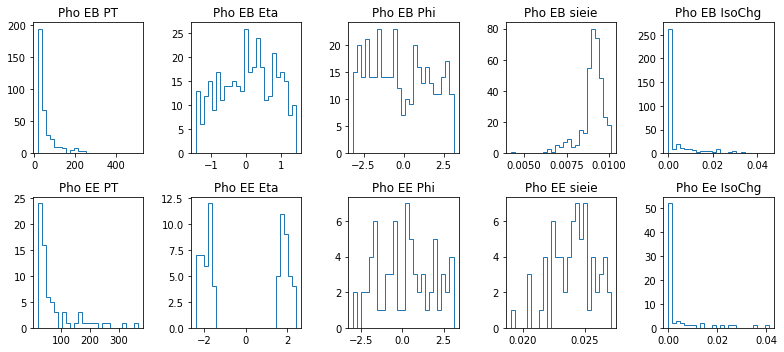

In [41]:
fig,axs = plt.subplots(2,5,figsize=(11,5))
bins=25

axs[0,0].hist(Pho_EB_PT,bins=bins,histtype='step')
axs[0,0].set_title('Pho EB PT')
axs[0,1].hist(Pho_EB_Eta,bins=bins,histtype='step')
axs[0,1].set_title('Pho EB Eta')
axs[0,2].hist(Pho_EB_Phi,bins=bins,histtype='step')
axs[0,2].set_title('Pho EB Phi')
axs[0,3].hist(Pho_EB_sieie,bins=bins,histtype='step')
axs[0,3].set_title('Pho EB sieie')
axs[0,4].hist(Pho_EB_Iso_charge,bins=bins,histtype='step')
axs[0,4].set_title('Pho EB IsoChg')


axs[1,0].hist(Pho_EE_PT,bins=bins,histtype='step')
axs[1,0].set_title('Pho EE PT')
axs[1,1].hist(Pho_EE_Eta,bins=bins,histtype='step')
axs[1,1].set_title('Pho EE Eta')
axs[1,2].hist(Pho_EE_Phi,bins=bins,histtype='step')
axs[1,2].set_title('Pho EE Phi')
axs[1,3].hist(Pho_EE_sieie,bins=bins,histtype='step')
axs[1,3].set_title('Pho EE sieie')
axs[1,4].hist(Pho_EE_Iso_charge,bins=bins,histtype='step')
axs[1,4].set_title('Pho Ee IsoChg')

plt.tight_layout()
plt.show()

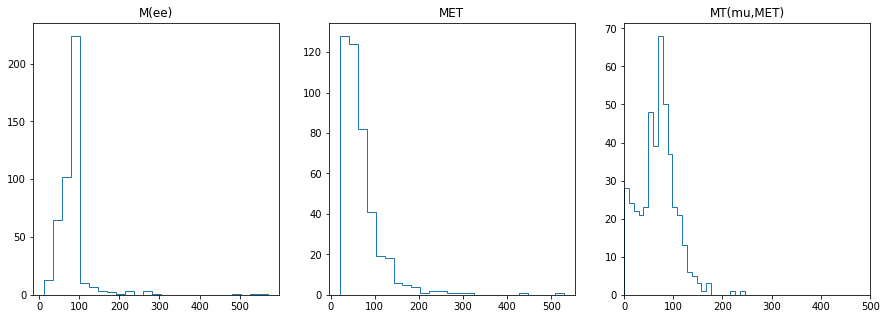

In [62]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
bins=25

axs[0].hist(Mee,bins=bins,histtype='step')
axs[0].set_title('M(ee)')

axs[1].hist(met,bins=bins,histtype='step')
axs[1].set_title('MET')


axs[2].hist(MT,bins=bins,histtype='step')
axs[2].set_title('MT(mu,MET)')
axs[2].set_xlim([0,500])
plt.show()

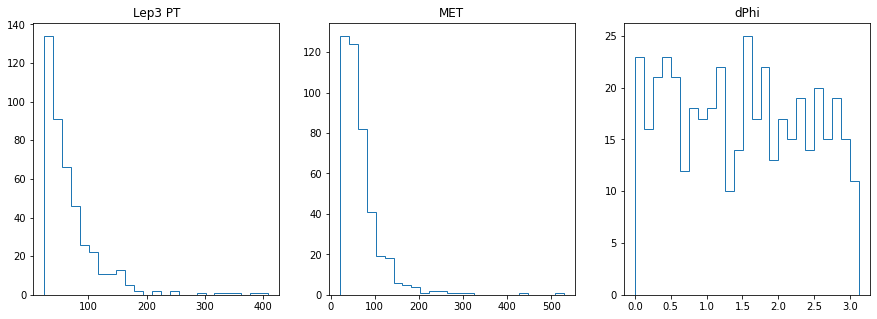

In [66]:
fig,axs = plt.subplots(1,3,figsize=(15,5))

axs[0].hist(muPT,bins=bins,histtype='step')
axs[0].set_title('Lep3 PT')

axs[1].hist(met,bins=bins,histtype='step')
axs[1].set_title('MET')

axs[2].hist(dPhi_mumet,bins=bins,histtype='step')
axs[2].set_title('dPhi')
plt.show()